## Homework 4

Use this notebook as a starter

In [114]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [115]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-05 23:21:29--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.11’

CreditScoring.csv.1 100%[===================>] 178,21K   874KB/s    in 0,2s    

2021-10-05 23:21:30 (874 KB/s) - ‘CreditScoring.csv.11’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [116]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [117]:
display(df.head())

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [118]:
from collections import Counter



Some of the features are encoded as numbers. Use the following code to de-code them:

In [119]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [120]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [121]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [122]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [123]:
df_numerical = df.select_dtypes(include=['number']).dtypes
df_categorical = df.select_dtypes(include=['object']).dtypes

display("Numerical:",df_numerical,"Categorical:",df_categorical)


'Numerical:'

seniority    int64
time         int64
age          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
default      int64
dtype: object

'Categorical:'

home       object
marital    object
records    object
job        object
dtype: object

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

- 60% - train set
- 20% - validation set
- 20% - test set


In [124]:
from sklearn.model_selection import train_test_split


df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)

In [125]:
len(df)

4454

In [126]:
len(df_full_train),len(df_test)

(3563, 891)

In [127]:
df_train , df_val = train_test_split(df_full_train,test_size=0.25,random_state=42) # From full train split 

In [128]:
len(df_train),len(df_val),len(df_test)

(2672, 891, 891)

In [129]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [130]:
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer


numerical = ['seniority', 'time', 'age', 'expenses', 'income',
             'assets', 'debt', 'price']
categorical = ['job', 'home']

scores = []

variables = ['seniority', 'time','income', 'debt']

for column in df[numerical]:
        auc = roc_auc_score(y_train,df_train[column])
        
        if auc < 0.5:
                auc = roc_auc_score(y_train,-df_train[column])
                scores.append(auc)
        print("%s  %.2f "% (column,auc))

        scores.append(auc)

print(" Max score:%.2f " % max(scores))


seniority  0.71 
time  0.55 
age  0.58 
expenses  0.50 
income  0.68 
assets  0.63 
debt  0.50 
price  0.51 
 Max score:0.71 


Answer: seniority

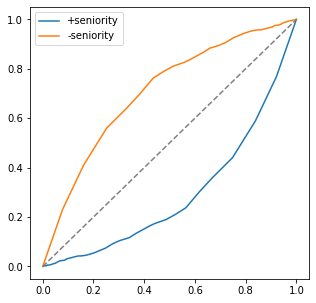

In [131]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.seniority)
plt.plot(fpr, tpr, label='+seniority')

fpr, tpr, _ = roc_curve(y_train, -df_train.seniority)
plt.plot(fpr, tpr, label='-seniority')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

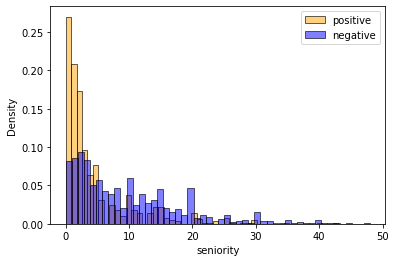

In [132]:
sns.histplot(df_train.seniority[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(df_train.seniority[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

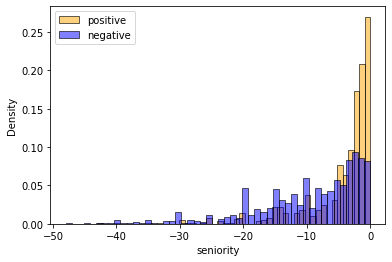

In [133]:
sns.histplot(-df_train.seniority[y_train == 1],
             stat='density', bins=50,
             color='orange', alpha=0.5,
             label='positive')
sns.histplot(-df_train.seniority[y_train == 0],
             stat='density', bins=50,
             color='blue', alpha=0.5,
             label='negative')

plt.legend()
plt.show()

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

`ANS:seniority`

In [134]:
scores

[0.7072070265500922,
 0.7072070265500922,
 0.553397866920394,
 0.5772204136160843,
 0.5772204136160843,
 0.502308853995237,
 0.502308853995237,
 0.6768358120610827,
 0.6768358120610827,
 0.6348311265879854,
 0.6348311265879854,
 0.5046771753290756,
 0.5079976655612195,
 0.5079976655612195]

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [135]:
from sklearn.linear_model import LogisticRegression

variables= ['seniority', 'income', 'assets', 'records', 'job', 'home']

def train(df_train,y_train,C=1.0):
    dicts= df_train[variables].to_dict(orient='records')
    dv= DictVectorizer(sparse=False) # One hot enconding
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)
    return dv,model


In [136]:
def predict(df, dv, model):
    dicts = df[variables].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred


In [137]:
dv, model = train(df_train, y_train, C=1.0)


## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [138]:
y_pred = predict(df_val,dv,model)

In [139]:
roc_auc_score(y_val, y_pred)


0.8194783158492367

In [140]:
val_dict = df_val[variables].to_dict(orient='records')

X_val = dv.transform(val_dict)

y_pred_bin = model.predict(X_val)
roc_auc_score(y_val, y_pred_bin)


0.6631150079355862

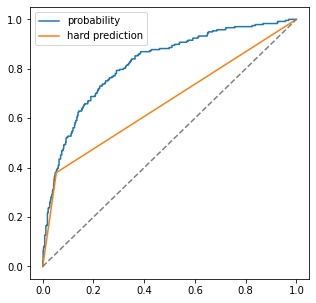

In [141]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='probability')

fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='hard prediction')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

plt.legend()
plt.show()

- The prediction curve should not be so linear

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [142]:
thresholds = np.linspace(0, 1, 101)


scores=[]

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


In [143]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fn)



In [144]:
df_scores.threshold.loc[[40]], df_scores['r'].loc[[40]]

(40    0.4
 Name: threshold, dtype: float64,
 40    0.630332
 Name: r, dtype: float64)

In [145]:
df_scores.threshold.loc[[40]], df_scores['p'].loc[[40]]

(40    0.4
 Name: threshold, dtype: float64,
 40    0.561181
 Name: p, dtype: float64)

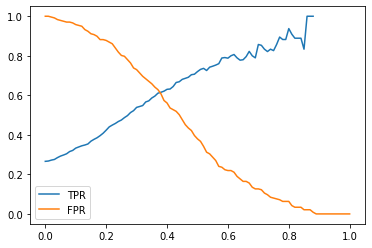

In [146]:
plt.plot(df_scores.threshold, df_scores['r'], label='TPR')
plt.plot(df_scores.threshold, df_scores['p'], label='FPR')
plt.legend()





At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [147]:
thresholds = np.linspace(0, 1, 101)


scores={}


for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    r = tp / (tp + fp)
    p = tp / (tp + fn)
    F1= 2 * ( p*r)/(p+r)

    scores[t]=F1
    

print("The F1 score is at its maximum value at:", (max(scores.items(), key=lambda x: x[1])))



The F1 score is at its maximum value at: (0.35000000000000003, 0.6202783300198806)


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

`ANS: 0.3` 

In [148]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)


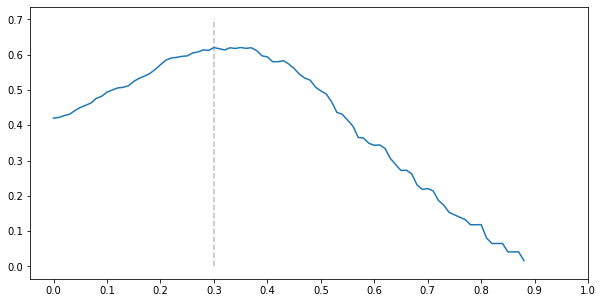

In [149]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.3, 0, 0.7, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()


## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [150]:
from sklearn.model_selection import KFold 


nfolds=5

kfold = KFold(n_splits=nfolds,shuffle=True,random_state=1)

In [151]:


aucs= []
    
for train_idx,val_idx in kfold.split(df_full_train):
        
        df_train = df_full_train.iloc[train_idx]
        y_train = df_train.default.values

        df_val =df_full_train.iloc[val_idx]
        y_val = df_val.default.values

        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)

        roc_auc = roc_auc_score(y_val,y_pred)
        aucs.append(roc_auc)

print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))


    

auc = 0.814 ± 0.015


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

`ANS:0.0.14`

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [152]:

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%5s, %.5f +- %.5f' % (C, np.mean(scores), np.std(scores)))


C= 0.01, 0.80855 +- 0.01255
C=  0.1, 0.81290 +- 0.01374
C=    1, 0.81223 +- 0.01367
C=   10, 0.81414 +- 0.01461


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

`ANS: C `

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.